In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import graphviz 
from sklearn.tree import export_graphviz

In [5]:
df = pd.read_csv('diabetes.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Решим задачу классификации  больных методом логистической регрессии и решающих деревьев используя стандартные настройки моделей.

In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_proba_tree = tree.predict_proba(X_test)[:, 1]

In [30]:
def print_metrics(y_true, y_pred, y_proba, model_name):
    print(f"\n{model_name}")
    print(f"F1: {f1_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.2f}")

In [31]:
print_metrics(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
print_metrics(y_test, y_pred_tree, y_proba_tree, "Decision Tree")


Logistic Regression
F1: 0.6804123711340206
Precision: 0.7674418604651163
Recall: 0.6111111111111112
Accuracy: 0.7987012987012987
ROC-AUC: 0.88

Decision Tree
F1: 0.5
Precision: 0.6052631578947368
Recall: 0.42592592592592593
Accuracy: 0.7012987012987013
ROC-AUC: 0.64


Логистическая регрессия показала более высокие значения F1-score и ROC-AUC, таким образом она лучше умеет разделять классы. Решающее дерево с настройками по умолчанию склонно к переобучению, что снижает его обобщающую способность. Таким образом, логистическая регрессия лучше подходит для данного датасета.

Исследуем значение метрики в зависимости от глубины решающего дерева. Построим график зависимости. Выберем метрику F1, так как классы в датасете несбалансированы

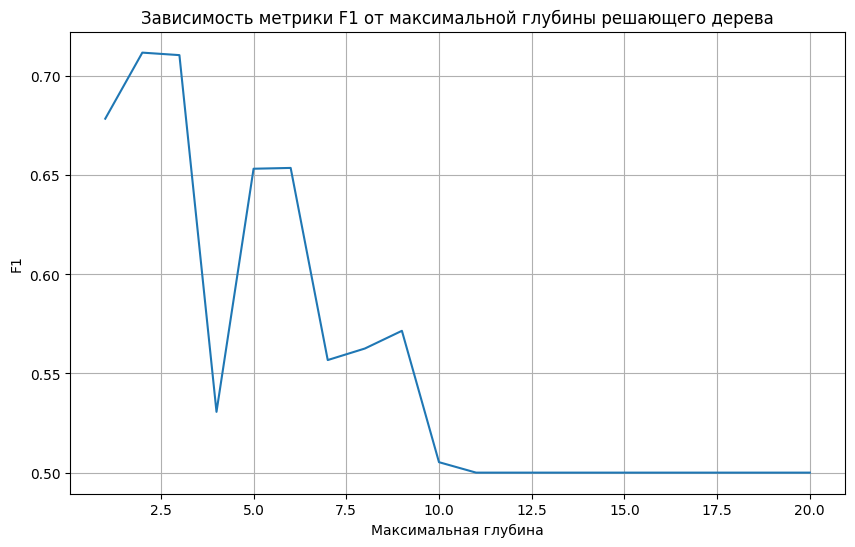

In [26]:
max_depths = range(1, 21)
f1_scores = []

for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=0)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_depths, f1_scores)
plt.title('Зависимость метрики F1 от максимальной глубины решающего дерева')
plt.xlabel('Максимальная глубина')
plt.ylabel('F1')
plt.grid(True)
plt.show()

In [32]:
optimal_depth = max_depths[f1_scores.index(max(f1_scores))]
print(f"Оптимальная глубина: {optimal_depth} (F1 = {max(f1_scores):.2f})")

Оптимальная глубина: 2 (F1 = 0.71)


Для  модели с оптимальной глубиной, отрисуем  получившееся дерево, важность признаков в виде столбчатой диаграммы, а также PR и ROC кривые

In [37]:
optimal_tree = DecisionTreeClassifier(max_depth=optimal_depth, random_state=0)
optimal_tree.fit(X_train, y_train)
y_proba = optimal_tree.predict_proba(X_test)[:, 1]

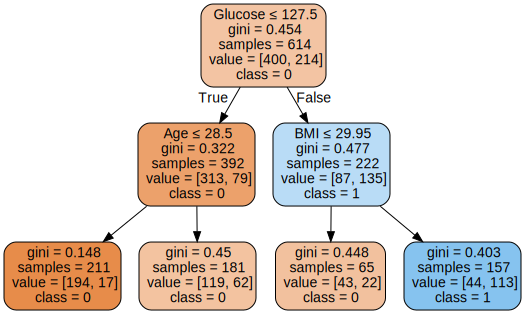

In [59]:
dot_data = export_graphviz(optimal_tree, out_file=None, 
                     feature_names=X.columns,  
                     class_names=["0", "1"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graphviz.Source(dot_data)  

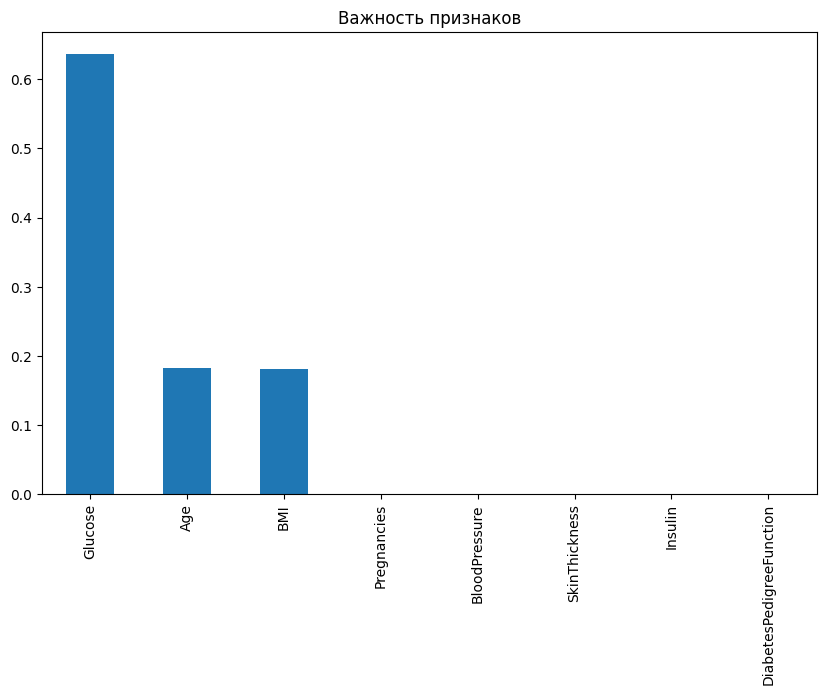

In [35]:
feature_importances = pd.Series(optimal_tree.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Важность признаков')
plt.show()

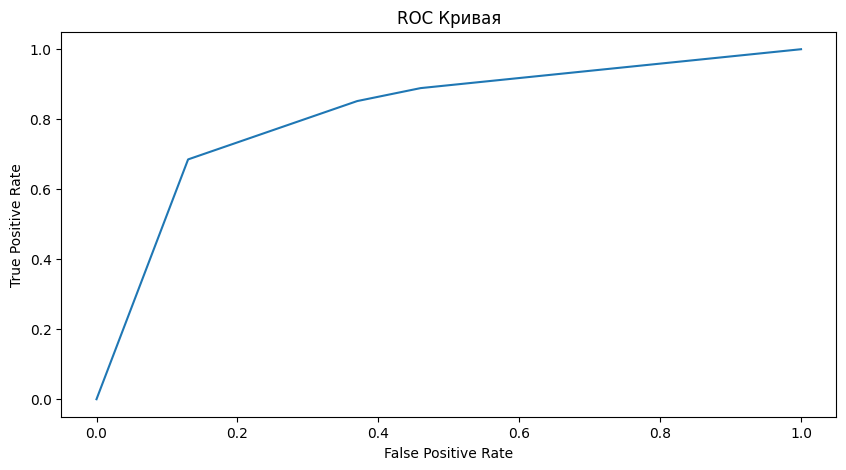

In [41]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Кривая')
plt.show()

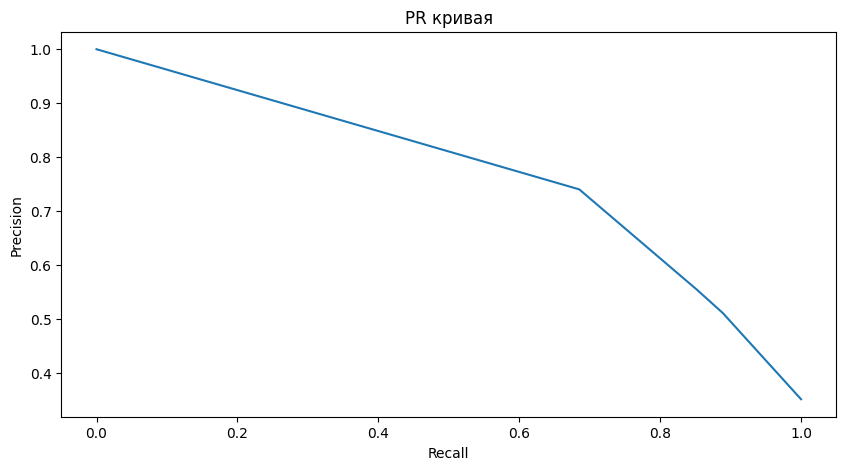

In [45]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR кривая')
plt.show()